# Relation Recommender for ArchiMate

In this notebook we are going to develop a relation recommender for ArchiMate using machine learning. For more info see [this article](https://github.com/m-steen/ml4ea#readme).

In [40]:
## Import required libraries
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics, model_selection, neighbors, preprocessing

## Collect training data

First we need to collect a sufficiently large and representative dataset with relevant features (columns) to train the recommender on. To start with, we have selected the following features:

- **sourceType**: the type of the source object of the relation;
- **targetType**: the type of the target object;
- **viewType**: the type of the view on which the relation appears.

The target for our predictions is:

- **relationType**: the type of the relation, being one of the 11 different ArchiMate relation types.

The [`scripts/`](scripts/) folder in this repository contains a [script](scripts/generate_training_data.script) that can be executed in Enterprise Studio to generate a dataset based on your own model package. After generating, copy the output of the script to a CSV file in the [`data/`](data/) folder of this project.

A sample of such a dataset is provided in the [`data/`](data/) folder already.

In [41]:
## Load the dataset
dataset = pd.read_csv('data/training_data.csv')
dataset.sample(5)

,sourceType,targetType,viewType,relationType
88849,ArchiMate:BusinessProduct,ArchiMate:TechnologyService,ArchiMate:AllView,ArchiMate:AggregationRelation
88391,ArchiMate:BusinessProduct,ArchiMate:BusinessRole,ArchiMate:BusinessProductView,ArchiMate:UseRelation
65715,ArchiMate:BusinessEvent,ArchiMate:BusinessProcess,ArchiMate:AllView,ArchiMate:FlowRelation
58006,ArchiMate:ApplicationService,ArchiMate:ApplicationComponent,ArchiMate:AllView,ArchiMate:UseRelation
51405,ArchiMate:ApplicationService,ArchiMate:ApplicationComponent,ArchiMate:AllView,ArchiMate:UseRelation


In [42]:
## Explore the dataset
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135803 entries, 0 to 135802
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   sourceType    135803 non-null  object
 1   targetType    135803 non-null  object
 2   viewType      135803 non-null  object
 3   relationType  135803 non-null  object
dtypes: object(4)
memory usage: 4.1+ MB


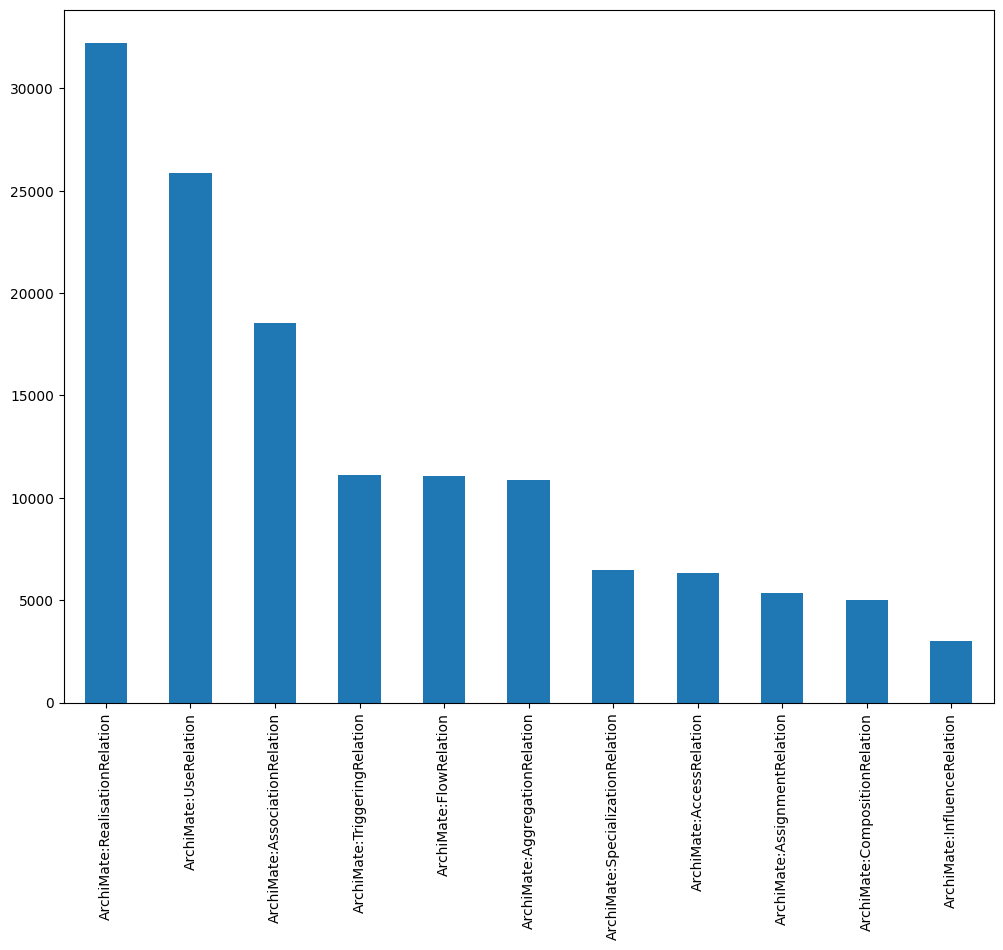

In [17]:
## Check the distribution of the relation types in the dataset
plt.figure(figsize=(12,9))
dataset['relationType'].value_counts().plot.bar()
plt.show()

If there is a lot of imbalance in the dataset, this may skew the learning towards the more frequent cases. In that case, consider to remove some of the more frequent cases.

## Preprocessing

The data needs to be converted to numbers and split into a training set and a random test set. The test set we will later use to verify how accurate the recommendations are on unseen samples.

In [8]:
## Split the dataset
## X represents the matrix with the features
## y represents the list of target values

features = ['sourceType', 'targetType', 'viewType']
target = 'relationType'
X = dataset[features]
y = dataset[target]
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.3, random_state=42)

## Convert to numbers
featureEncoder = preprocessing.OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
featureEncoder.fit(X_train)
X_train = featureEncoder.transform(X_train)
X_test  = featureEncoder.transform(X_test)
relationEncoder = preprocessing.LabelEncoder()
relationEncoder.fit(y_train)
y_train = relationEncoder.transform(y_train)
y_test  = relationEncoder.transform(y_test)

In [9]:
## Verify that the relationEncoder contains a class for each of the 11 ArchiMate relation types
pd.Series(relationEncoder.classes_)

0             ArchiMate:AccessRelation
1        ArchiMate:AggregationRelation
2         ArchiMate:AssignmentRelation
3        ArchiMate:AssociationRelation
4        ArchiMate:CompositionRelation
5               ArchiMate:FlowRelation
6          ArchiMate:InfluenceRelation
7        ArchiMate:RealisationRelation
8     ArchiMate:SpecializationRelation
9         ArchiMate:TriggeringRelation
10               ArchiMate:UseRelation
dtype: object

## Training

Predicting the relation type for a given set of input values (sourceType, targetType and viewType) is a classification problem. Because our dataset contains many examples of existing relations we can apply a supervised-learning strategy. 

There are many algorithms available for supervised classification learning. Here we have chosen the K Nearest Neighbors (KNN) classifier as provided by the [SciKit Learn library](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html). The KNN classifier takes a majority vote of the _k_ nearest neighbors to the requested data point to predict the target label. Below we use `k = 5`, but you can try out different values for the number of neighbors.

In [49]:
classifier = neighbors.KNeighborsClassifier(n_neighbors=5, weights='distance')
classifier.fit(X_train, y_train)

KNeighborsClassifier(weights='distance')

## Evaluation

The quality of the classifier can be assessed by testing its accuracy against the test dataset.

In [50]:
## First evaluate the performance of the classifier against the training dataset
predictions = classifier.predict(X_train)

print('Model performance on the training set:')
print(metrics.classification_report(y_train, predictions, target_names=relationEncoder.classes_))
print("Accuracy:", metrics.accuracy_score(y_train, predictions))

Model performance on the training set:
                                  precision    recall  f1-score   support

        ArchiMate:AccessRelation       0.95      0.98      0.96      4488
   ArchiMate:AggregationRelation       0.71      0.67      0.69      7588
    ArchiMate:AssignmentRelation       0.85      0.98      0.91      3721
   ArchiMate:AssociationRelation       0.80      0.65      0.72     13051
   ArchiMate:CompositionRelation       0.76      0.61      0.68      3498
          ArchiMate:FlowRelation       0.63      0.67      0.65      7739
     ArchiMate:InfluenceRelation       0.78      0.86      0.82      2126
   ArchiMate:RealisationRelation       0.87      0.97      0.92     22542
ArchiMate:SpecializationRelation       0.55      0.32      0.40      4547
    ArchiMate:TriggeringRelation       0.71      0.86      0.77      7805
           ArchiMate:UseRelation       0.88      0.87      0.87     17957

                        accuracy                           0.80     950

In [51]:
## Evaluate the classifier against the test dataset
predictions = classifier.predict(X_test)

print('Model performance on the training set:')
print(metrics.classification_report(y_test, predictions, target_names=relationEncoder.classes_))
print("Accuracy:", metrics.accuracy_score(y_test, predictions))

Model performance on the training set:
                                  precision    recall  f1-score   support

        ArchiMate:AccessRelation       0.94      0.99      0.97      1824
   ArchiMate:AggregationRelation       0.71      0.66      0.68      3275
    ArchiMate:AssignmentRelation       0.85      0.97      0.91      1627
   ArchiMate:AssociationRelation       0.78      0.64      0.71      5501
   ArchiMate:CompositionRelation       0.75      0.63      0.69      1505
          ArchiMate:FlowRelation       0.62      0.66      0.64      3310
     ArchiMate:InfluenceRelation       0.76      0.87      0.81       875
   ArchiMate:RealisationRelation       0.87      0.97      0.92      9687
ArchiMate:SpecializationRelation       0.52      0.29      0.37      1914
    ArchiMate:TriggeringRelation       0.71      0.85      0.78      3329
           ArchiMate:UseRelation       0.88      0.87      0.87      7894

                        accuracy                           0.80     407

## Conclusions

We cannot expect the predictions to be correct always, but an accuracy score of 0.8 or higher is quite good already. That means the recommender is giving correct predictions in 80% of the test cases.

Our dataset is likely to contain a lot of duplicate entries. As a result, there will be some overlap between the training dataset and the test set. For a more critical evaluation we should perhaps remove the duplicates from the test set, such that we only test with really unseen cases. This is left as an exercise to the reader.

With the code below you can request recommendations for your own data.

In [52]:
## Input
sourceType = 'ArchiMate:ApplicationComponent'
targetType = 'ArchiMate:BusinessProcess'
viewType   = 'ArchiMate:AllView'

## Predict a relation type
X = pd.DataFrame([[sourceType, targetType, viewType]], columns=['sourceType', 'targetType', 'viewType'])
X = featureEncoder.transform(X)
prediction = classifier.predict(X)

## Output
recommendation = relationEncoder.inverse_transform(prediction)[0]
print('Recommended relation:', recommendation)

Recommended relation: ArchiMate:UseRelation
